# Segment the entire image

In [1]:
import sys
import lightning as L
import torch
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

sys.path.append("..")

from models import SegmentationModule
from data import LEM_Full_Module, IBGE_Full_Module
from utils import load_from_checkpoint, get_data_sample, time_series_to_rgb, get_preds_from_logits

/home/gabriel/Documentos/Mestrado/sat-series-segmentation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CONFIG_FILE_PATH = "../configs/train_config_local.yaml"

config = OmegaConf.load(CONFIG_FILE_PATH)
config

{'model': {'task': 'segmentation', 'backbone': 'mae', 'decoder': 'segformer', 'img_size': 96, 'num_channels': 10, 'num_frames': 2, 'num_classes': 3, 'patch_size': 8}, 'dataset': {'name': 'lem_full', 'validate': True, 'batch_size': 32, 'num_workers': 4, 'data_dir': '/media/gabriel/Dados/Datasets/LEM_dataset', 'city_id': 2919553}, 'solver': {'name': 'adam', 'criterion': 'dice', 'learning_rate': 0.001, 'class_weights': None, 'weight_decay': None, 'warmup_epochs': None, 'max_epochs': 100, 'dev_run': False, 'overfit_batches': False}, 'checkpoint': {'save_dir': '/home/gabriel/Documentos/Mestrado/experiments/ibge_inference', 'run_name': 'mae_segformer_weighted', 'pretrain_weights': None, 'ckpt_path': '/home/gabriel/Documentos/Mestrado/experiments/best_model.ckpt', 'save_checkpoint': True}}

In [3]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

#### Forcing CPU usage
device = "cpu"
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
####

print(f"Using device: {device}")

model_name = SegmentationModule

model = model_name(config)
model = load_from_checkpoint(config, model, model_name=model_name)
model = model.to(device)

Using device: cpu


In [ ]:
data_module = LEM_Full_Module(config)
data_module.setup()

In [5]:
H, W = dataset.full_img["data"].shape[-2:]
print("Full image size:", (H, W))

full_logits = torch.zeros((config.model.num_classes, H, W), dtype=torch.float32)
count_map = torch.zeros((H, W), dtype=torch.float32)

for sample in tqdm(dataloader):
    sample["data"] = sample["data"].to(device)

    with torch.no_grad():
        outputs = model(sample)
    
    patch_size = config.model.img_size

    for i in range(outputs["logits"].size(0)):
        top, left = sample["coords"][i]
        full_logits[:, top:top+patch_size, left:left+patch_size] += outputs["logits"][i].cpu()
        count_map[top:top+patch_size, left:left+patch_size] += 1

full_logits /= count_map.clamp_min(1e-6)
probs = full_logits.softmax(dim=0)
pred = probs.argmax(dim=0)

Full image size: (11750, 6574)


  0%|          | 0/428 [00:00<?, ?it/s]

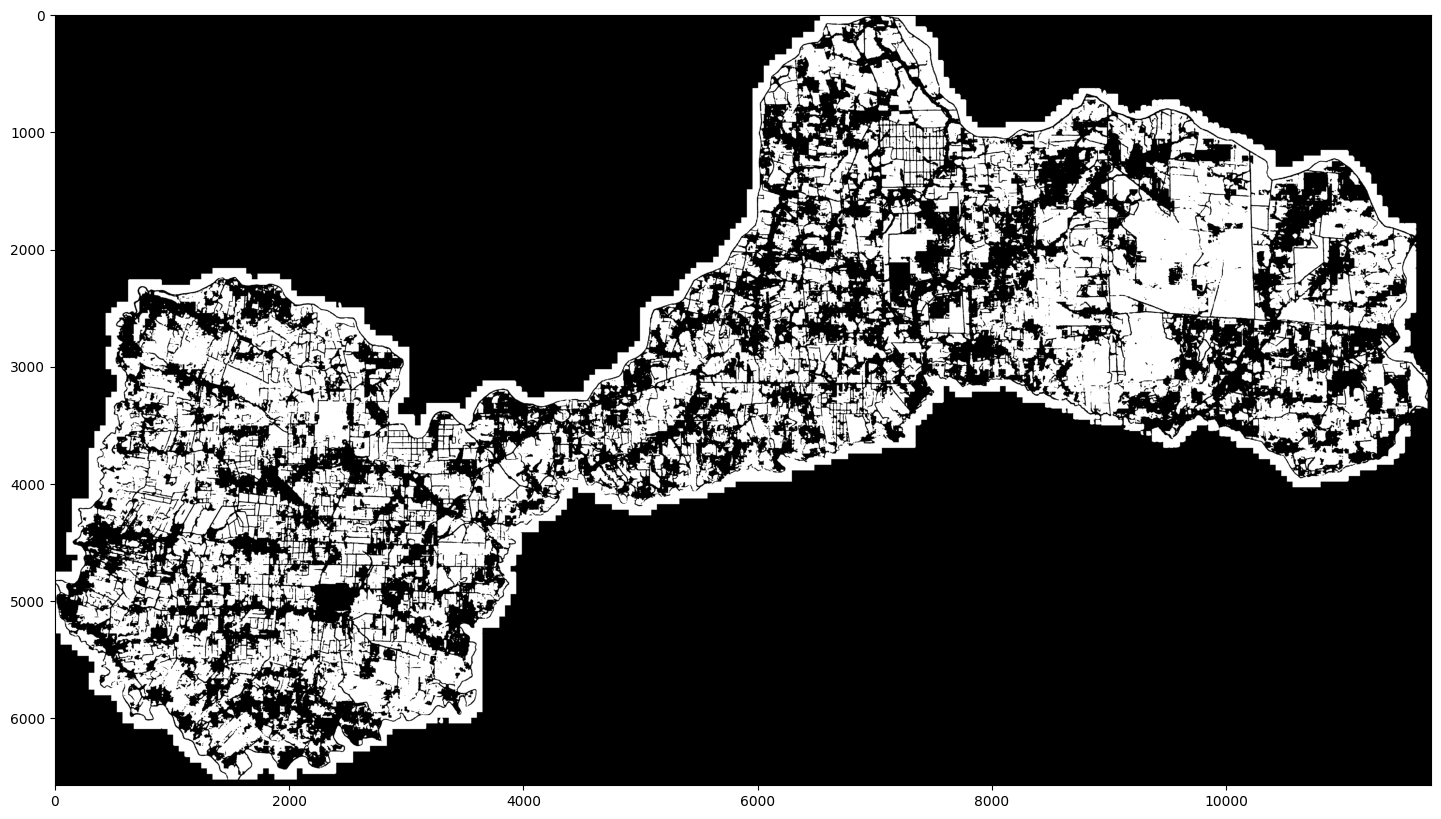

In [9]:
filtered_pred = pred.clone()
filtered_pred[pred == 2] = 0

plt.figure(figsize=(20, 10))
plt.imshow(filtered_pred.T, cmap="gray")
plt.show()